In [1]:
%load_ext autoreload
%autoreload 2
import sys, os
sys.path.append('../src/')
from Biologging_Toolkit.applications.Rain import Rain
from Biologging_Toolkit.applications.Wind import Wind
import Biologging_Toolkit.utils.rain_empirical_utils as R_Utils

d:\STAGE\ENSTA\SES_tags\notebooks\../src\Biologging_Toolkit


In [2]:
depids = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_293a','ml20_296b','ml20_313a','ml21_295a','ml21_305b']
depids_wo293 = ['ml17_280a','ml18_296a','ml18_294b','ml19_292a','ml19_292b','ml19_293a','ml19_294a','ml20_296b','ml20_313a','ml21_295a','ml21_305b'] #'ml20_293a',

path = 'G:/individus_filtered'
freqs = [500, 1000, 2500, 5000, 8000, 10000, 12000, 15000, 16000,20000]
features_csv = ['downwards_mean_500', 'downwards_mean_1000', 'downwards_mean_2500',
       'downwards_mean_5000', 'downwards_mean_8000', 'downwards_mean_10000',
       'downwards_mean_12000', 'downwards_mean_15000', 'downwards_mean_16000','upwards_mean_20000','upwards_mean_5000']

In [14]:
deps = ["ml17_280a","ml18_296a"]
inst = Rain(depid=deps, path=[path+f"/{depid}" for depid in deps], df_data = 'csv')

<unknown>:188: SyntaxWarning: invalid escape sequence '\ '
<unknown>:188: SyntaxWarning: invalid escape sequence '\ '


ml17_280a
ml18_296a


---
# Detection
---

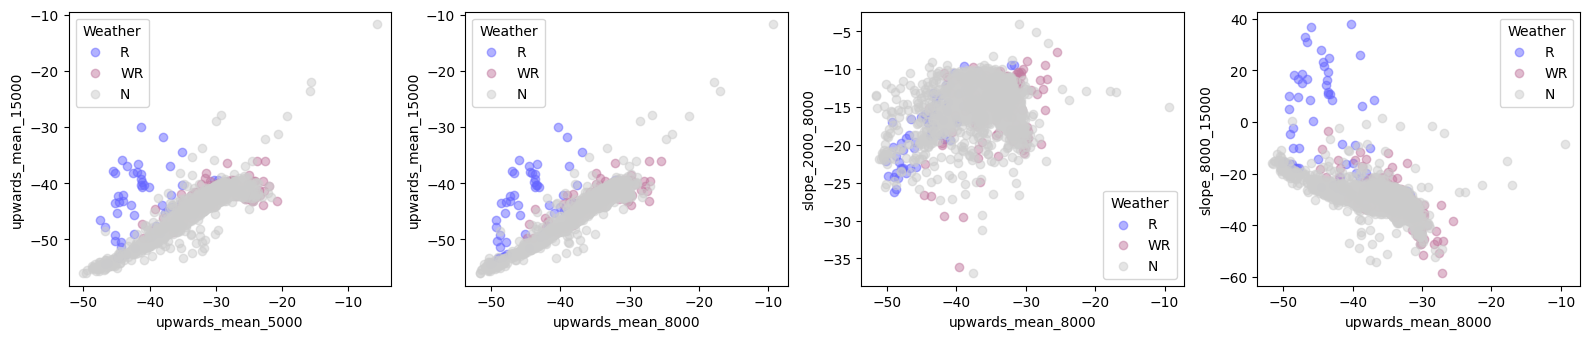

In [15]:
R_Utils.plot_spl_rain(inst.df)

In [16]:
inst.classify_rain()

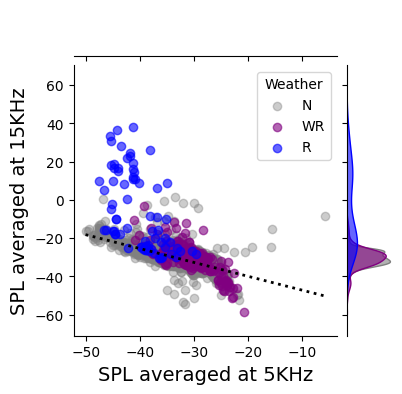

slope_8000_15000 = -0.726061647999723*upwards_mean_5000 - 54.4897542002666
y = -0.7260616479997232 * x + -54.48975420026658


In [17]:
R_Utils.plot_weather_SPL_regression(inst.df,x = "upwards_mean_5000", y = "slope_8000_15000", height=4)

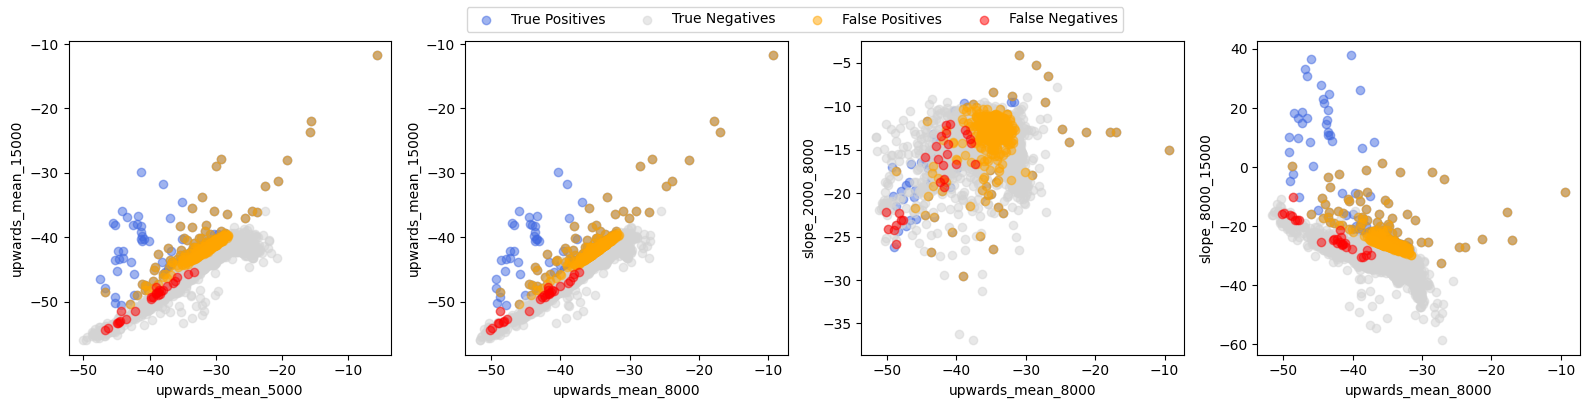

In [18]:
R_Utils.plot_classification_spl(inst.df)

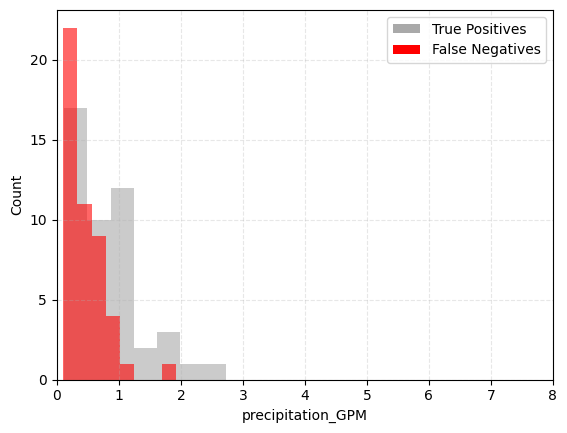

In [19]:
R_Utils.plot_classification_histogram(inst.df)

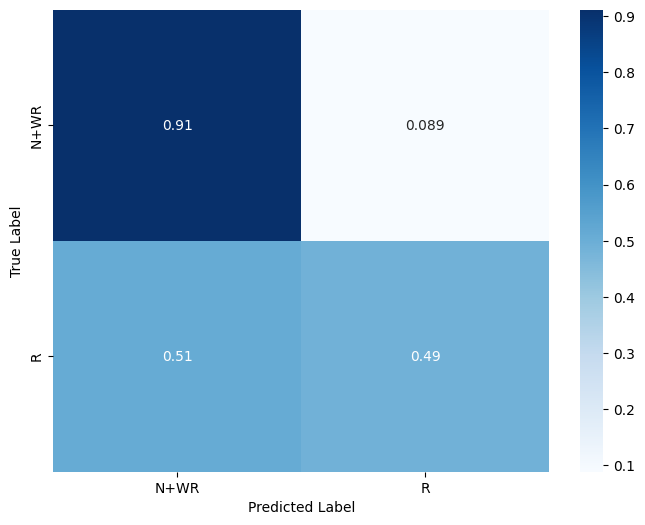

In [20]:
R_Utils.plot_confusion_matrix(inst.df)

---
# Estimation
---

In [21]:
print(inst.df["depid"].value_counts())

depid
ml18_296a    3344
ml17_280a    1859
Name: count, dtype: int64


- faire depid fit custom
- faire skffit custom

# Ajout de Spectral Slope

In [3]:
# Method from 'A Supervised Machine Learning Approach to Classify the Acoustic Behaviour of Marine Mammals' by M. C. L. de Jong et al. (2023)
def calculate_and_add_slope(df, freq1, freq2):
    slope_column_name = f"slope_{freq1}_{freq2}"
    spl1 = df[f'upwards_mean_{freq1}']
    spl2 = df[f'upwards_mean_{freq2}']
    delta_spl = spl2 - spl1
    delta_log_freq = np.log10(freq2) - np.log10(freq1)
    slope = delta_spl / delta_log_freq
    df[slope_column_name] = slope 
    return df

# Detection

## ml17_280a_dive.csv

In [26]:
depid = depids[0]
df = pd.read_csv(f"{path}/{depid}/{depid}_dive.csv")
df = calculate_and_add_slope(df, freq1=2000, freq2=8000)
df = calculate_and_add_slope(df, freq1=8000, freq2=15000)

<Axes: >

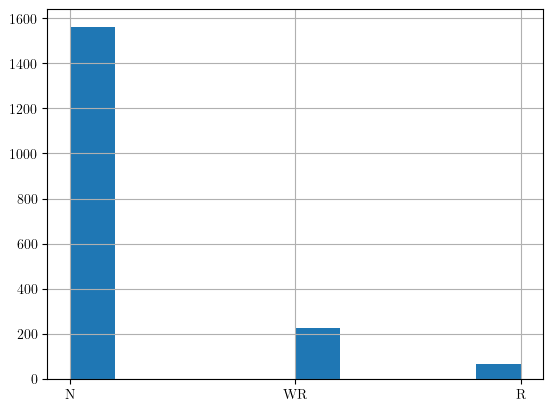

In [27]:
wind_tresh = 7
conditions = [
    (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < wind_tresh),
    (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] >= wind_tresh),
    # (df["precipitation_GPM"] <= 0.1) & (df["wind_speed"] >= 7)
]
choices = ["R", "WR"]#, "W"]
df["weather"] = np.select(conditions, choices, default="N")

df = df.dropna(subset=["precipitation_GPM","upwards_mean_5000","upwards_mean_8000","upwards_mean_15000","slope_2000_8000","slope_8000_15000"])
df["weather"].hist()

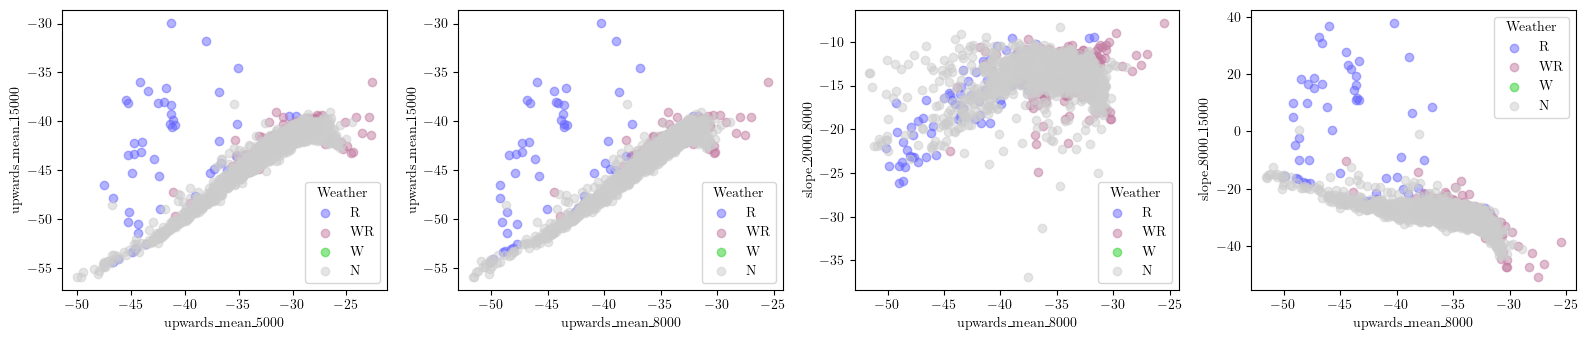

In [28]:
R_Utils.plot_spl_rain(df)

In [1]:
polydeg = 1
quant_val = 0.8
x = "upwards_mean_8000"
y = "slope_8000_15000"

quantile_df = pd.DataFrame({})
for bin in range(-55, -25, 5):
    _df = df[(df[x] > bin) & (df[x] < bin + 5)]
    threshold = _df[y].quantile(quant_val)
    _df.loc[_df[y] > threshold, y] = np.nan
    _df = _df.dropna(subset=[x, y])
    quantile_df = pd.concat([quantile_df, _df])

model = np.poly1d(np.polyfit(quantile_df[x], quantile_df[y], polydeg))
x_Symb = Symbol(x)

palette = {
    'N': 'gray',
    'WR': 'purple',
    'R': 'blue',
    # 'W': 'green'
}

g = sns.JointGrid(data=df, x=x, y=y, hue='weather', palette=R_Utils.weather4_colors, height=8)

for weather_type, color in palette.items():
    if weather_type != "W" :
        subset = df[df['weather'] == weather_type]
        g.ax_joint.scatter(subset[x], subset[y], c=color, alpha=0.4 if weather_type=='N' else 0.6, label=weather_type)

# start change
# for weather_type, color in palette.items():
#     subset = df[df['weather'] == weather_type]
#     if weather_type == "R":
#         scatter = g.ax_joint.scatter(
#             subset[x], subset[y],
#             c=subset["precipitation_GPM"],
#             cmap="summer_r",
#             # alpha=0.6,
#             label=weather_type
#         )
#         cbar = plt.colorbar(scatter, ax=g.ax_joint, label="Precipitation (GPM)")
#     else:
#         g.ax_joint.scatter(
#             subset[x], subset[y],
#             c=color,
#             alpha=0.4 if weather_type == 'N' else 0.6,
#             label=weather_type
#         )
# end change

x_vals = np.linspace(df[x].min(), df[x].max(), 100)
y_vals = model(x_vals)
g.ax_joint.plot(x_vals, y_vals, ':', color="black", linewidth=2)

for weather_type, color in palette.items():
    subset = df[df['weather'] == weather_type]
    sns.kdeplot(data=subset, x=x, ax=g.ax_marg_x, fill=True, alpha=0.6, color=color)
    sns.kdeplot(data=subset, y=y, ax=g.ax_marg_y, fill=True, alpha=0.6, color=color)

g.ax_joint.set_xlabel("SPL averaged at 5KHz", fontsize=14)
g.ax_joint.set_ylabel("SPL averaged at 15KHz", fontsize=14)
g.ax_joint.legend(title="Weather")


plt.show()
print(f"{y} = {expand(model(x_Symb))}")
a, b = model.coefficients
print(f"y = {a} * x + {b}")


NameError: name 'pd' is not defined

slope_8000_15000=-0.811757978029764*upwards_mean_8000 - 58.3118084938084


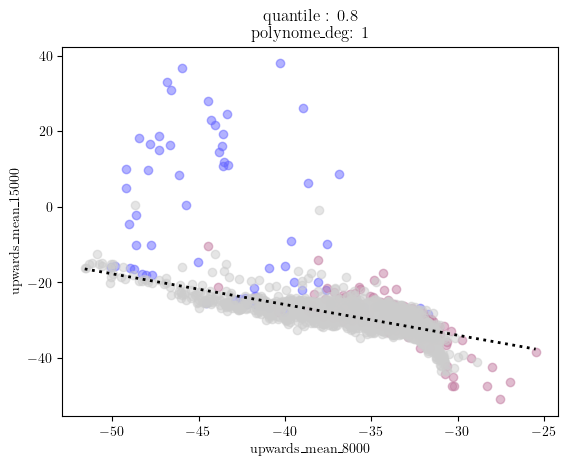

In [30]:
quantile_df = pd.DataFrame({})
polydeg = 1
quant_val = 0.8

x = "upwards_mean_8000"
y = "slope_8000_15000"

for bin in range(-55,-25,5):
    _df = df[(df[x] > bin) & (df[x] < bin+5)]
    
    threshold = _df[y].quantile(quant_val)
    _df.loc[_df[y] > threshold, y] = np.nan
    _df = _df.dropna(subset=[x, y])

    quantile_df = pd.concat([quantile_df, _df])

for weather_type, color in R_Utils.weather4_colors.items():
    subset = df[df['weather'] == weather_type]
    plt.scatter(
        subset[x],
        subset[y],
        c=color,
        alpha=0.5,
        label=weather_type
    )
model = np.poly1d(np.polyfit(quantile_df[x], quantile_df[y], polydeg))
x_Symb=Symbol(x)
print(f"{y}={expand(model(x_Symb))}")

x_vals = np.linspace(df[x].min(), df[x].max(), 100)
y_vals = model(x_vals)
plt.plot(x_vals, y_vals, ':', color="black", linewidth=2)
plt.title(f'quantile : {quant_val}\n polynome_deg: {polydeg}')
plt.xlabel(x)
plt.ylabel('upwards_mean_15000')
plt.show()

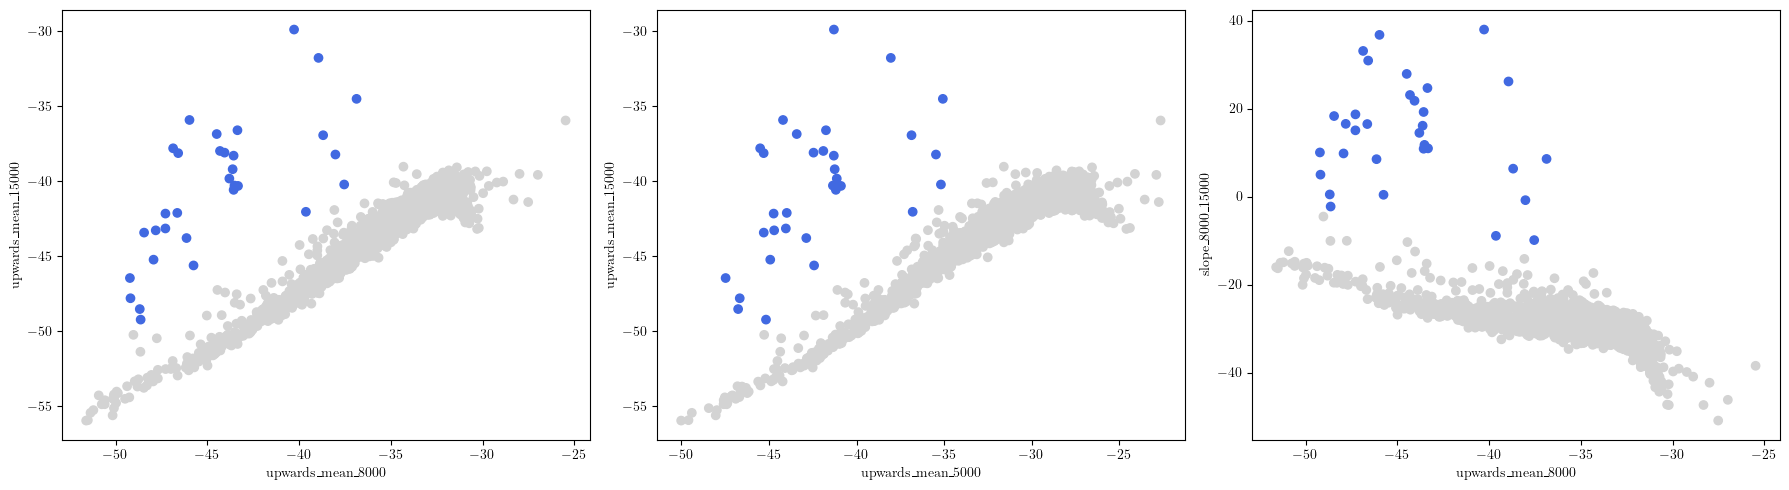

In [31]:
combinations = [("upwards_mean_5000","upwards_mean_15000"),("upwards_mean_8000","upwards_mean_15000"),("upwards_mean_8000","slope_8000_15000")]
coefs = []
for comb in combinations:

    polydeg = 1
    quant_val = 0.8

    quantile_df = pd.DataFrame({})
    for bin in range(-55, -25, 5):
        _df = df[(df[comb[0]] > bin) & (df[comb[0]] < bin + 5)]
        threshold = _df[comb[1]].quantile(quant_val)
        _df.loc[_df[comb[1]] > threshold, comb[1]] = np.nan
        _df = _df.dropna(subset=[comb[0], comb[1]])
        quantile_df = pd.concat([quantile_df, _df])

    model = np.poly1d(np.polyfit(quantile_df[comb[0]], quantile_df[comb[1]], polydeg))
    x_Symb = Symbol(comb[1])

    x_vals = np.linspace(df[comb[1]].min(), df[comb[1]].max(), 100)
    y_vals = model(x_vals)
    
    a, b = model.coefficients
    coefs.append((comb[0], comb[1], a, b))

conditions = [
    (df[coefs[0][1]]>coefs[0][2]*df[coefs[0][0]] +coefs[0][3]+2) & 
    (df[coefs[1][1]]>coefs[1][2]*df[coefs[1][0]] +coefs[1][3]+4) & 
    (df[coefs[2][1]]>coefs[2][2]*df[coefs[2][0]] +coefs[2][3]+1) 
]

choices = ["R"]
df["Rain_Type_preds"] = np.select(conditions, choices, default="N")
color_map = {"R": "royalblue", "N": "lightgrey"}
colors = df["Rain_Type_preds"].map(color_map)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].scatter(df["upwards_mean_8000"], df["upwards_mean_15000"], color=colors)
axes[0].set_xlabel("upwards_mean_8000")
axes[0].set_ylabel("upwards_mean_15000")

axes[1].scatter(df["upwards_mean_5000"], df["upwards_mean_15000"], color=colors)
axes[1].set_xlabel("upwards_mean_5000")
axes[1].set_ylabel("upwards_mean_15000")

axes[2].scatter(df["upwards_mean_8000"], df["slope_8000_15000"], color=colors)
axes[2].set_xlabel("upwards_mean_8000")
axes[2].set_ylabel("slope_8000_15000")

plt.tight_layout()
plt.show()

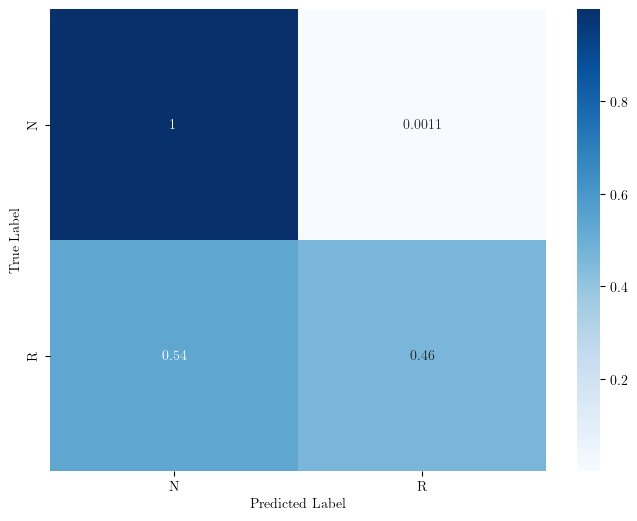

In [32]:
conditions = [
    (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < 7)
]
choices = ["R"]
df["Rain_Type"] = np.select(conditions, choices, default="N")

cm = confusion_matrix(df["Rain_Type"], df["Rain_Type_preds"], normalize="true")


labels = df["Rain_Type"].unique()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)#, fmt='d' )
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

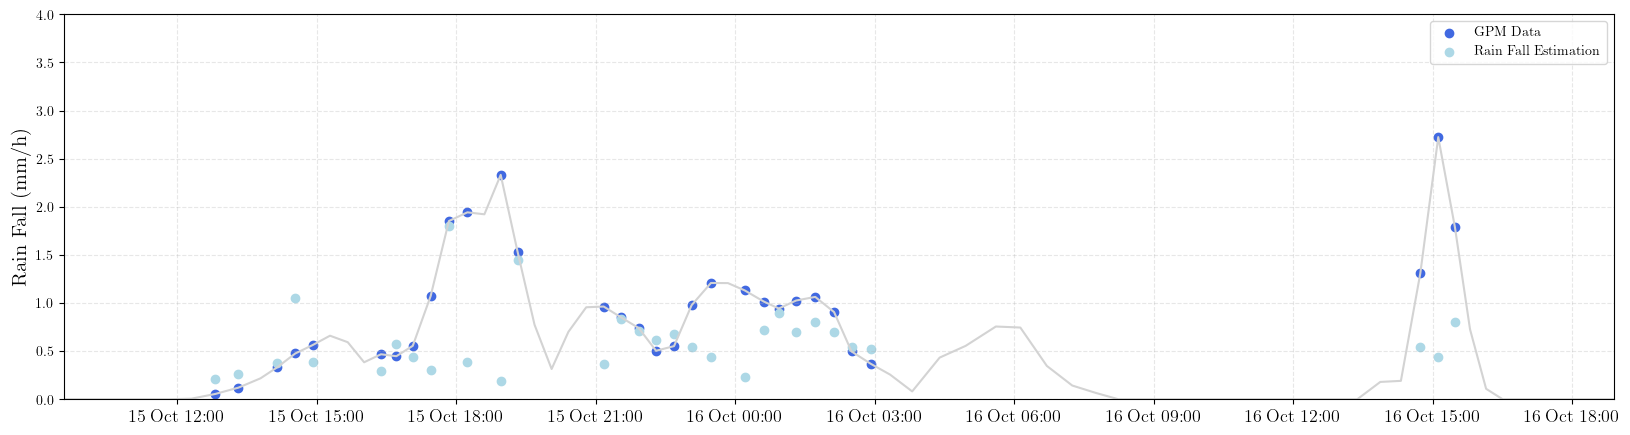

In [41]:
df_r = df[df["Rain_Type_preds"]=="R"].copy()
df_r["begin_time"] = pd.to_datetime(df_r["begin_time"], unit='s')
df["begin_time"] = pd.to_datetime(df["begin_time"], unit='s')

plt.figure(figsize=(20,5))
plt.plot(df["begin_time"],df["precipitation_GPM"], c="lightgrey")
plt.scatter(df_r["begin_time"],df_r["precipitation_GPM"], c="royalblue", label='GPM Data')
plt.scatter(df_r["begin_time"],10**((df_r["upwards_mean_15000"]+35)/20), c="lightblue", label='Rain Fall Estimation')
# plt.xlabel("Time (2017)")
plt.ylabel("Rain Fall (mm/h)",fontsize=15)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d %b %H:%M'))
plt.xlim(pd.to_datetime(6e4 + 1.508e9, unit='s', utc=True),
         pd.to_datetime(1.8e5 + 1.508e9, unit='s', utc=True))
plt.xticks(fontsize=13)
plt.ylim(0,4)
plt.grid(True, linestyle="--", alpha=0.3)
# plt.savefig("../../data-exploration/exports/article/empEst_true_time.pdf")

plt.show()

### Valeurs de la biblio

In [ ]:
y_true = df_r["precipitation_GPM"]
# y_est = 0.5*10**((df_r["upwards_mean_5000"]-42.5)/15.4)
y_est = 10**((df_r["upwards_mean_15000"]+35)/20)

mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
mse = mean_squared_error(y_true=y_true, y_pred=y_est)
rmse = root_mean_squared_error(y_true=y_true, y_pred=y_est)
r2 = r2_score(y_true=y_true, y_pred=y_est)
CC=np.corrcoef(y_true, y_est)[0, 1]

print(f'mse:{mse}\nmae:{mae}\nrmse:{rmse}\nr2:{r2}\nCC:{CC}')

mse:1.047074595382314
mae:0.5580944540411161
rmse:1.0232666296632145
r2:-0.1015004748518451
CC:0.19955877746986764


### Valeurs optimisées sur nos données

In [57]:
rslts = {}
y_true = df_r["precipitation_GPM"]

for spl in ["upwards_mean_500","upwards_mean_1000","upwards_mean_2000","upwards_mean_5000","upwards_mean_8000","upwards_mean_10000","upwards_mean_12000","upwards_mean_15000","upwards_mean_16000"]:
    def objective(trial):
        a = trial.suggest_float("a", 20, 40)
        b = trial.suggest_float("b", 20, 50)
        y_est = 10 ** ((df_r[spl] + a) / b)
        mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
        return mae

    optuna.logging.set_verbosity(optuna.logging.ERROR)
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=1000)
    # print("Best parameters:", study.best_params)
    print(spl)

    y_est = 10**((df_r[spl]+study.best_params["a"])/study.best_params["b"])

    mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
    mse = mean_squared_error(y_true=y_true, y_pred=y_est)
    rmse = root_mean_squared_error(y_true=y_true, y_pred=y_est)
    r2 = r2_score(y_true=y_true, y_pred=y_est)
    CC=np.corrcoef(y_true, y_est)[0, 1]

    rslts[spl] = {
        "mse": mse,
        "mae": mae,
        "rmse": rmse,
        "r2": r2,
        "CC": CC
    }

    # print(f'mse:{mse}\nmae:{mae}\nrmse:{rmse}\nr2:{r2}\nCC:{CC}\n')

upwards_mean_500
upwards_mean_1000
upwards_mean_2000
upwards_mean_5000
upwards_mean_8000
upwards_mean_10000
upwards_mean_12000
upwards_mean_15000
upwards_mean_16000


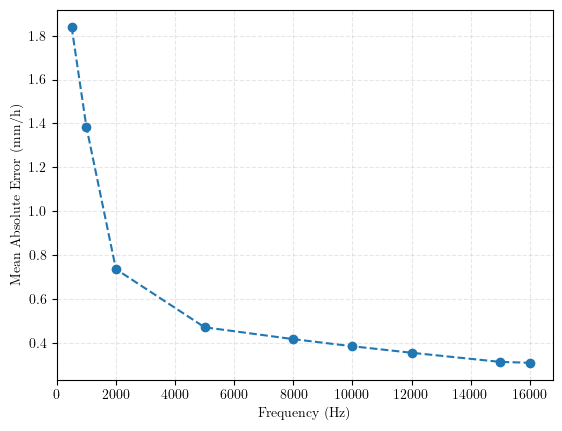

In [58]:
x_vals = [float(re.search(r'[-+]?\d*\.?\d+', key).group()) for key in rslts.keys()]
y_vals = [rslts[key]["mae"] for key in rslts.keys()]

plt.plot(x_vals, y_vals, marker='o', linestyle="--")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Mean Absolute Error (mm/h)")
# plt.ylim(0,1)
plt.xlim(0)
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()


## ml17_280 : dives.npz

In [47]:
depid = depids[0]
df_csv = pd.read_csv(f"{path}/{depid}/{depid}_dive.csv")

rows = []
for idx, dive in tqdm(df_csv.iterrows(), total=len(df_csv)):

#on ne teste l'estimation que sur les dives qui ont été filtrées par le detecteur avec dive.csv
# for idx, dive in tqdm(df_r.iterrows(), total=len(df_r)):
    npz_path = os.path.join(path, depid, "dives", f"acoustic_dive_{idx:05d}.npz")
    npz_data = np.load(npz_path)
    
    time = npz_data["time"]
    precip = npz_data["precipitation_GPM"]
    ws = npz_data["ws"]
    upwards_mean_15000 = npz_data["spectro"].T[480]
    upwards_mean_8000 = npz_data["spectro"].T[256]
    upwards_mean_5000 = npz_data["spectro"].T[160]
    upwards_mean_2000 = npz_data["spectro"].T[64]
    for i in range(len(time)):
        rows.append({
            "begin_time": time[i],
            "precipitation_GPM": float(precip),
            "wind_speed": float(ws),
            "upwards_mean_15000": upwards_mean_15000[i],
            "upwards_mean_8000": upwards_mean_8000[i],
            "upwards_mean_5000": upwards_mean_5000[i],
            "upwards_mean_2000": upwards_mean_2000[i]
        })

df_npz = pd.DataFrame(rows)
print(df_npz.shape)

100%|██████████| 1859/1859 [00:14<00:00, 124.87it/s]


(881451, 7)


In [53]:
df_moyennes = df_npz.groupby(df_npz.index // 60).median()
# df_test= df_npz["wind_speed"].groupby(df_npz.index // 60).median()


print(df_moyennes.shape)
df_moyennes = df_moyennes.dropna(subset=["precipitation_GPM", "upwards_mean_15000", "upwards_mean_8000", "upwards_mean_5000", "upwards_mean_2000"])

df = df_moyennes.copy()

df = calculate_and_add_slope(df, freq1=2000, freq2=8000)
df = calculate_and_add_slope(df, freq1=8000, freq2=15000)

(14691, 7)


<Axes: >

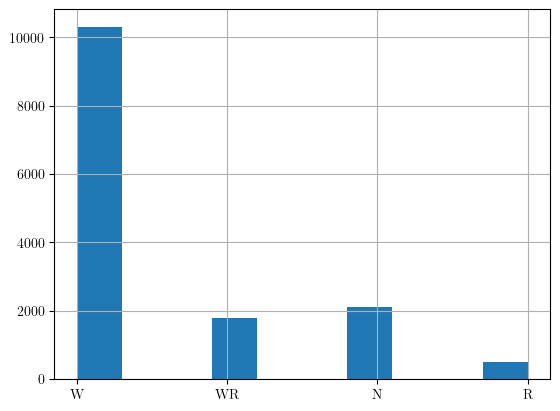

In [54]:
conditions = [
    (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < 7),
    (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] >= 7),
    (df["precipitation_GPM"] <= 0.1) & (df["wind_speed"] >= 7)
]
choices = ["R", "WR", "W"]
df["weather"] = np.select(conditions, choices, default="N")

df = df.dropna(subset=["precipitation_GPM","upwards_mean_5000","upwards_mean_8000","upwards_mean_15000","slope_2000_8000","slope_8000_15000"])
df["weather"].hist()

### Detection

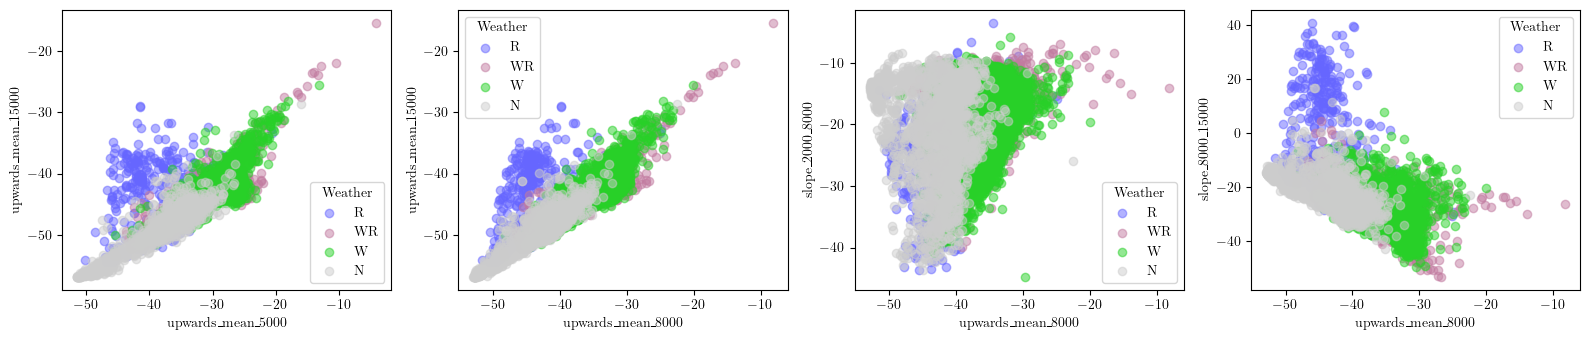

In [50]:
R_Utils.plot_spl_rain(df)

upwards_mean_15000=0.74128509114236*upwards_mean_8000 - 17.4289873766895


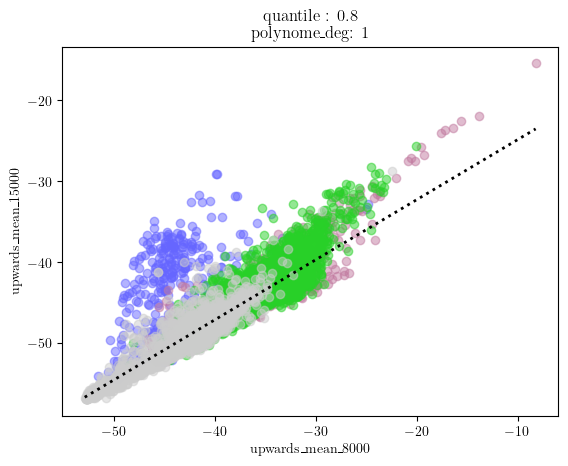

In [56]:
quantile_df = pd.DataFrame({})
polydeg = 1
quant_val = 0.8

x = "upwards_mean_8000"
y = "upwards_mean_15000"

for bin in range(-55,-25,5):
    _df = df[(df[x] > bin) & (df[x] < bin+5)]
    
    threshold = _df[y].quantile(quant_val)
    _df.loc[_df[y] > threshold, y] = np.nan
    _df = _df.dropna(subset=[x, y])

    quantile_df = pd.concat([quantile_df, _df])

for weather_type, color in R_Utils.weather4_colors.items():
    subset = df[df['weather'] == weather_type]
    plt.scatter(
        subset[x],
        subset[y],
        c=color,
        alpha=0.5,
        label=weather_type
    )
model = np.poly1d(np.polyfit(quantile_df[x], quantile_df[y], polydeg))
x_Symb=Symbol(x)
print(f"{y}={expand(model(x_Symb))}")

x_vals = np.linspace(df[x].min(), df[x].max(), 100)
y_vals = model(x_vals)
plt.plot(x_vals, y_vals, ':', color="black", linewidth=2)
plt.title(f'quantile : {quant_val}\n polynome_deg: {polydeg}')
plt.xlabel(x)
plt.ylabel('upwards_mean_15000')
plt.show()

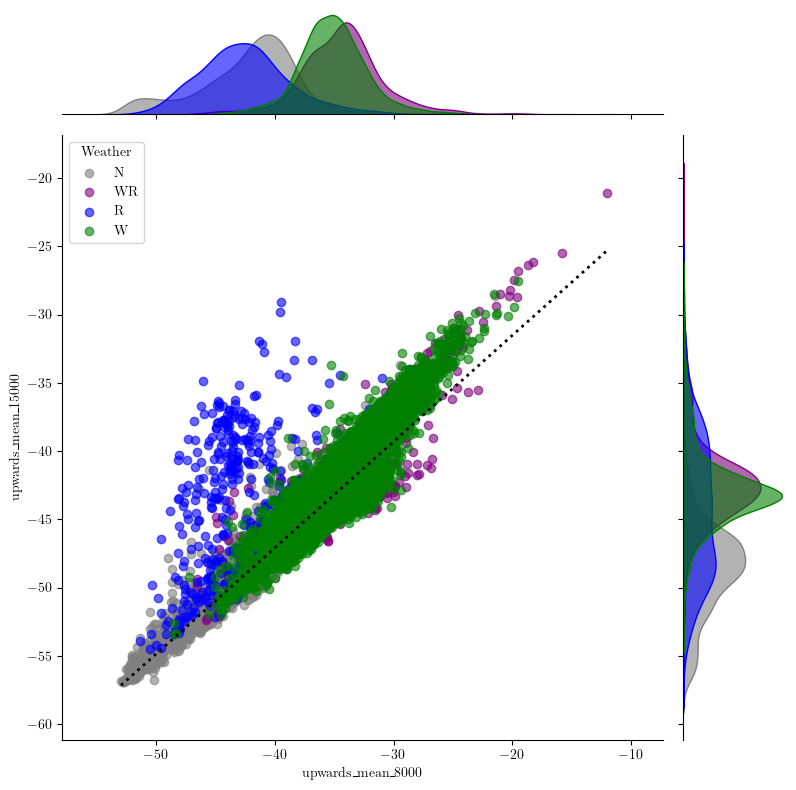

upwards_mean_15000 = 0.777806574130188*upwards_mean_8000 - 15.9604193333233


In [26]:
polydeg = 1
quant_val = 0.8
x = "upwards_mean_8000"
y = "upwards_mean_15000"

quantile_df = pd.DataFrame({})
for bin in range(-55, -25, 5):
    _df = df[(df[x] > bin) & (df[x] < bin + 5)]
    threshold = _df[y].quantile(quant_val)
    _df.loc[_df[y] > threshold, y] = np.nan
    _df = _df.dropna(subset=[x, y])
    quantile_df = pd.concat([quantile_df, _df])

model = np.poly1d(np.polyfit(quantile_df[x], quantile_df[y], polydeg))
x_Symb = Symbol(x)

palette = {
    'N': 'gray',
    'WR': 'purple',
    'R': 'blue',
    'W': 'green'
}

g = sns.JointGrid(data=df, x=x, y=y, hue='weather', palette=R_Utils.weather4_colors, height=8)

for weather_type, color in palette.items():
    # if weather_type!='W':
        subset = df[df['weather'] == weather_type]
        g.ax_joint.scatter(subset[x], subset[y], c=color, alpha=0.6, label=weather_type)

x_vals = np.linspace(df[x].min(), df[x].max(), 100)
y_vals = model(x_vals)
g.ax_joint.plot(x_vals, y_vals, ':', color="black", linewidth=2)

for weather_type, color in palette.items():
    subset = df[df['weather'] == weather_type]
    sns.kdeplot(data=subset, x=x, ax=g.ax_marg_x, fill=True, alpha=0.6, color=color)
    sns.kdeplot(data=subset, y=y, ax=g.ax_marg_y, fill=True, alpha=0.6, color=color)

g.ax_joint.set_xlabel(x)
g.ax_joint.set_ylabel(y)
g.ax_joint.legend(title="Weather")

plt.show()
print(f"{y} = {expand(model(x_Symb))}")


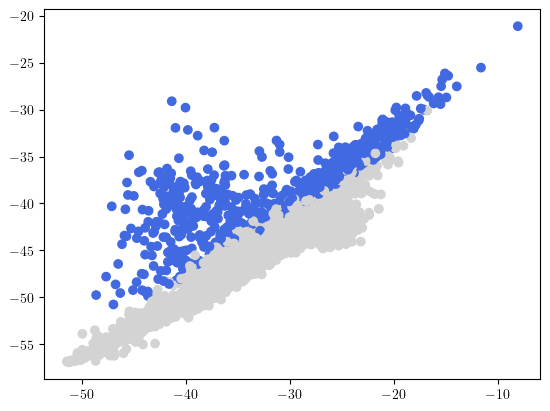

In [13]:
conditions = [
    (df["upwards_mean_15000"]>0.777806574130188*df["upwards_mean_8000"] - 15.9604193333233+2) & 
    (df["upwards_mean_15000"]>0.675120468405572*df["upwards_mean_5000"] - 22.7162654445649+2) &
    (df["slope_8000_15000"]>-0.732888248882517*df["upwards_mean_8000"] - 55.7631513248787+2)
]

choices = ["R"]
df["Rain_Type_preds"] = np.select(conditions, choices, default="N")
color_map = {"R": "royalblue", "N": "lightgrey"}
colors = df["Rain_Type_preds"].map(color_map)

plt.scatter(df["upwards_mean_5000"], df["upwards_mean_15000"], color=colors)

### Estimation

In [ ]:
train_df, test_df = train_test_split(
    df_moyennes, test_size=0.7, random_state=42, stratify=df_moyennes["precipitation_GPM"]>0.1)

In [77]:
y_true = train_df["precipitation_GPM"]

def objective(trial):
    a = trial.suggest_float("a", 1, 100)
    b = trial.suggest_float("b", 1, 100)
    y_est = 10 ** ((train_df["upwards_mean_15000"] + a) / b)
    mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
    return mae

optuna.logging.set_verbosity(optuna.logging.ERROR)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=500)
print("Best parameters:", study.best_params)

y_true = test_df["precipitation_GPM"]
y_est = 10**((test_df["upwards_mean_15000"]+study.best_params["a"])/study.best_params["b"])

mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
mse = mean_squared_error(y_true=y_true, y_pred=y_est)
rmse = root_mean_squared_error(y_true=y_true, y_pred=y_est)
r2 = r2_score(y_true=y_true, y_pred=y_est)

print(f'mse:{mse}\nmae:{mae}\nrmse:{rmse}\nr2:{r2}')

Best parameters: {'a': 21.34667555834623, 'b': 2.9030625181133014}
mse:0.28346814716455077
mae:0.14321242504462534
rmse:0.5324172679060577
r2:-0.07782584171585571


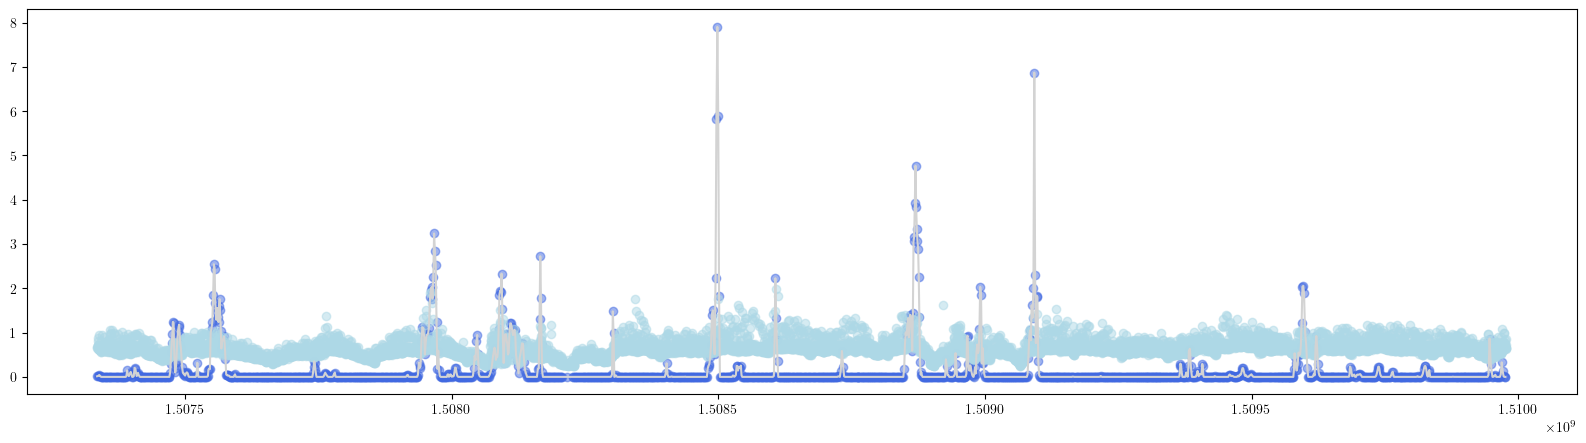

In [95]:
df_r = df[df["Rain_Type_preds"]=="R"]


plt.figure(figsize=(20,5))
plt.plot(df_csv["begin_time"],df_csv["precipitation_GPM"], c="lightgrey")
plt.scatter(df_csv["begin_time"],df_csv["precipitation_GPM"], c="royalblue", alpha=0.5)
plt.scatter(test_df["begin_time"],10**((test_df["upwards_mean_15000"]+36)/35), c="lightblue", alpha=0.5)
# plt.xlim(6e4+1.508e9,1.8e5+1.508e9)
# plt.ylim(0,4)

# Detection for all depid

In [4]:
def classify_rain(df, offset = 4, optimised_tresh=False):
    combinations = [("upwards_mean_5000","upwards_mean_15000"),("upwards_mean_8000","upwards_mean_15000"),("upwards_mean_8000","slope_8000_15000")]
    coefs = []
    for comb in combinations:

        polydeg = 1
        quant_val = 0.8

        quantile_df = pd.DataFrame({})
        for bin in range(-55, -25, 5):
            _df = df[(df[comb[0]] > bin) & (df[comb[0]] < bin + 5)]
            threshold = _df[comb[1]].quantile(quant_val)
            _df.loc[_df[comb[1]] > threshold, comb[1]] = np.nan
            _df = _df.dropna(subset=[comb[0], comb[1]])
            quantile_df = pd.concat([quantile_df, _df])

        model = np.poly1d(np.polyfit(quantile_df[comb[0]], quantile_df[comb[1]], polydeg))
        x_Symb = Symbol(comb[1])

        x_vals = np.linspace(df[comb[1]].min(), df[comb[1]].max(), 100)
        y_vals = model(x_vals)
        
        a, b = model.coefficients
        coefs.append((comb[0], comb[1], a, b))

    if optimised_tresh:
        conditions = [
            (df[coefs[0][1]]>coefs[0][2]*df[coefs[0][0]] +coefs[0][3]+offset/2) & 
            (df[coefs[1][1]]>coefs[1][2]*df[coefs[1][0]] +coefs[1][3]+offset) & 
            (df[coefs[2][1]]>coefs[2][2]*df[coefs[2][0]] +coefs[2][3]+offset/4) 
        ]
    else :
        conditions = [
            (df[coefs[0][1]]>coefs[0][2]*df[coefs[0][0]] +coefs[0][3]+offset) & 
            (df[coefs[1][1]]>coefs[1][2]*df[coefs[1][0]] +coefs[1][3]+offset) & 
            (df[coefs[2][1]]>coefs[2][2]*df[coefs[2][0]] +coefs[2][3]+offset) 
        ]

    choices = ["R"]
    df["Rain_Type_preds"] = np.select(conditions, choices, default="N+WR")

    conditions = [
        (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < 7)
    ]
    choices = ["R"]
    df["Rain_Type"] = np.select(conditions, choices, default="N+WR")
    return df

def create_df(path):
    df = pd.read_csv(path)
    df = calculate_and_add_slope(df, freq1=2000, freq2=8000)
    df = calculate_and_add_slope(df, freq1=8000, freq2=15000)
    wind_tresh = 7
    conditions = [
        (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] < wind_tresh),
        # (df["precipitation_GPM"] > 0.1) & (df["wind_speed"] >= wind_tresh),
        # (df["precipitation_GPM"] <= 0.1) & (df["wind_speed"] >= 7)
    ]
    choices = ["R"]#, "WR"]#, "W"]
    df["weather"] = np.select(conditions, choices, default="N+WR")

    df = df.dropna(subset=["precipitation_GPM","upwards_mean_5000","upwards_mean_8000","upwards_mean_15000","slope_2000_8000","slope_8000_15000"])
    return df

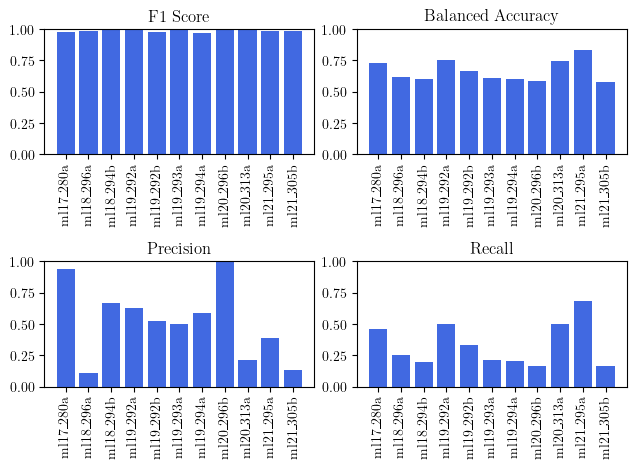

In [ ]:
fig, axs = plt.subplots(2, 2)
for depid in depids_wo293 :
    #prepa Dataset
    df = create_df(f"{path}/{depid}/{depid}_dive.csv")
    
    df = classify_rain(df, offset=4, optimised_tresh=True)

    cm = confusion_matrix(df["Rain_Type"], df["Rain_Type_preds"], normalize="true")

    labels = df["Rain_Type"].unique()

    y_true = df['Rain_Type']
    y_pred = df['Rain_Type_preds']
    
    if len(df["Rain_Type"].unique()) == len(df["Rain_Type_preds"].unique()):
        precision = sklearn.metrics.precision_score(y_true, y_pred,pos_label='R')
        recall = sklearn.metrics.recall_score(y_true, y_pred,pos_label='R')
        f1 = f1_score(y_true, y_pred, average="weighted")
        balanced_accuracy = balanced_accuracy_score(df["Rain_Type"], df["Rain_Type_preds"])
        axs[0, 0].bar(x=depid, height=f1, color='royalblue')
        axs[0, 1].bar(x=depid, height=balanced_accuracy, color='royalblue')
        axs[1, 0].bar(x=depid, height=precision, color='royalblue')
        axs[1, 1].bar(x=depid, height=recall, color='royalblue')
    else :
        axs[0, 0].bar(x=depid, height=0, color='red')
        axs[0, 1].bar(x=depid, height=0, color='royalblue')
        axs[1, 0].bar(x=depid, height=0, color='green')
        axs[1, 1].bar(x=depid, height=0, color='orange')

    axs[0,0].set_ylim(0,1)
    axs[0,1].set_ylim(0,1)
    axs[1,0].set_ylim(0,1)
    axs[1,1].set_ylim(0,1)

    axs[0,0].set_title("F1 Score")
    axs[0,1].set_title("Balanced Accuracy")
    axs[1,0].set_title("Precision")
    axs[1,1].set_title("Recall")

    axs[0,0].set_xticks(rotation=90, ticks=range(len(depids_wo293)), labels=depids_wo293)
    axs[0,1].set_xticks(rotation=90, ticks=range(len(depids_wo293)), labels=depids_wo293)
    axs[1,0].set_xticks(rotation=90, ticks=range(len(depids_wo293)), labels=depids_wo293)
    axs[1,1].set_xticks(rotation=90, ticks=range(len(depids_wo293)), labels=depids_wo293)


plt.tight_layout()

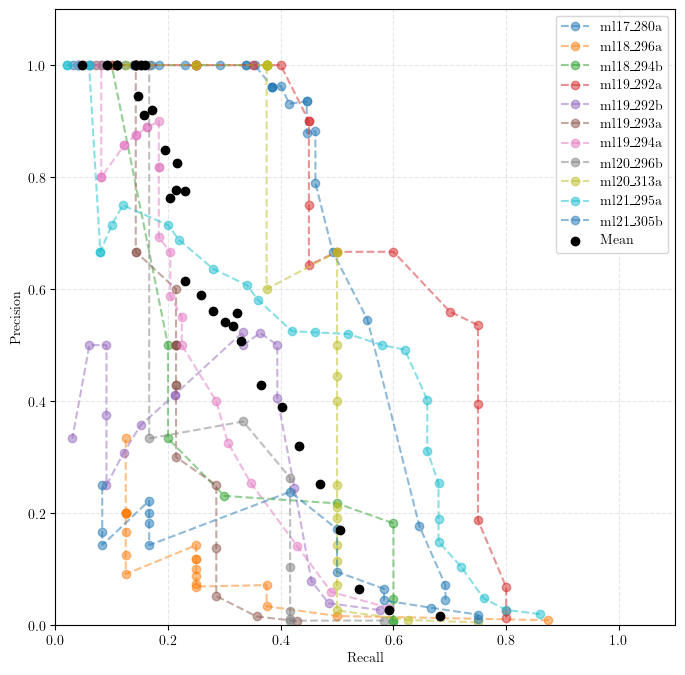

In [ ]:
rslts = {}
plt.figure(figsize=(8, 8))
for depid in depids_wo293: 
    x = []
    y = []

    df = create_df(f"{path}/{depid}/{depid}_dive.csv")
    for delta in np.arange(0, 15, 0.5):
        if str(delta) not in rslts:
            rslts[str(delta)] = {"x": [], "y": []}
        df = classify_rain(df, offset=delta, optimised_tresh=False)
        precision = sklearn.metrics.precision_score(df['Rain_Type'], df['Rain_Type_preds'],pos_label='R', zero_division=0)
        recall = sklearn.metrics.recall_score(df['Rain_Type'], df['Rain_Type_preds'],pos_label='R', zero_division=0)

        
        
        if recall!= 0 and precision!= 0:
            x.append(recall)
            y.append(precision)
            rslts[str(delta)]["x"].append(recall)
            rslts[str(delta)]["y"].append(precision)

    plt.plot(x, y, linestyle='--', marker='o', label=depid, alpha=0.5)

x_delta_curve = []
y_delta_curve = []
for delta in rslts.keys():
    x_delta_curve.append(np.mean(rslts[delta]["x"]))
    y_delta_curve.append(np.mean(rslts[delta]["y"]))

plt.scatter(x_delta_curve, y_delta_curve, marker="o" , color='black', label='Mean', zorder=5)
# plt.scatter(x_delta_curve[2], y_delta_curve[2], color='royalblue', s=100, zorder=5)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.grid(True, linestyle="--", alpha=0.3)

plt.legend()
# plt.savefig("../../data-exploration/exports/precision_recall_curve.pdf")

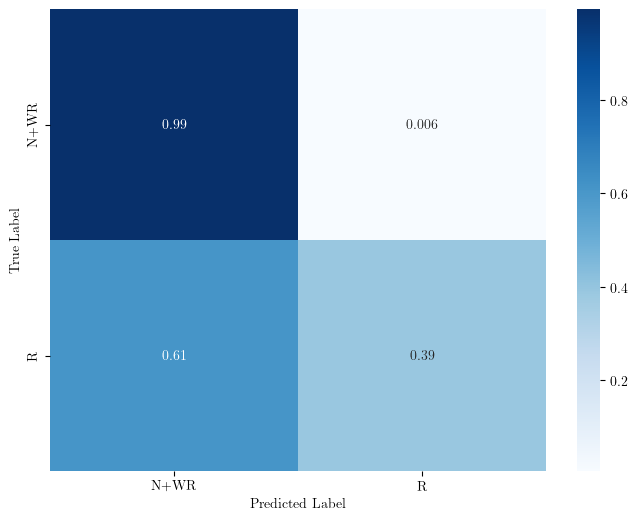

In [270]:
all_depid_df = pd.DataFrame({})
for depid in depids_wo293 :
    df = create_df(f"{path}/{depid}/{depid}_dive.csv")
    df = classify_rain(df, offset=4, optimised_tresh=True)
    all_depid_df = pd.concat([all_depid_df, df])
cm = confusion_matrix(all_depid_df["Rain_Type"], all_depid_df["Rain_Type_preds"], normalize="true")

labels = all_depid_df["Rain_Type"].unique()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)#, fmt='d' )
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [7]:
all_depid_df = pd.DataFrame({})
rslts = {}

for depid in depids_wo293 :
    print(f'>>{depid}')
    rslts[depid] = {}
    df = create_df(f"{path}/{depid}/{depid}_dive.csv")
    df = classify_rain(df, offset=1.25, optimised_tresh=False)
    df_r = df[df["Rain_Type_preds"]=="R"].copy()
    y_true = df_r["precipitation_GPM"]

    for spl in ["upwards_mean_500","upwards_mean_1000","upwards_mean_2000","upwards_mean_5000","upwards_mean_8000","upwards_mean_10000","upwards_mean_12000","upwards_mean_15000","upwards_mean_16000"]:
        def objective(trial):
            a = trial.suggest_float("a", 20, 40)
            b = trial.suggest_float("b", 20, 50)
            y_est = 10 ** ((df_r[spl] + a) / b)
            mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
            return mae

        optuna.logging.set_verbosity(optuna.logging.ERROR)
        study = optuna.create_study(direction="minimize")
        study.optimize(objective, n_trials=200)
        # print("Best parameters:", study.best_params)
        # print(spl)

        y_est = 10**((df_r[spl]+study.best_params["a"])/study.best_params["b"])

        mae = mean_absolute_error(y_true=y_true, y_pred=y_est)
        mse = mean_squared_error(y_true=y_true, y_pred=y_est)
        rmse = root_mean_squared_error(y_true=y_true, y_pred=y_est)
        r2 = r2_score(y_true=y_true, y_pred=y_est)
        CC=np.corrcoef(y_true, y_est)[0, 1]

        rslts[depid][spl] = {
            "mse": mse,
            "mae": mae,
            "rmse": rmse,
            "r2": r2,
            "CC": CC
        }
    

>>ml17_280a
>>ml18_296a
>>ml18_294b
>>ml19_292a
>>ml19_292b
>>ml19_293a
>>ml19_294a
>>ml20_296b
>>ml20_313a
>>ml21_295a
>>ml21_305b


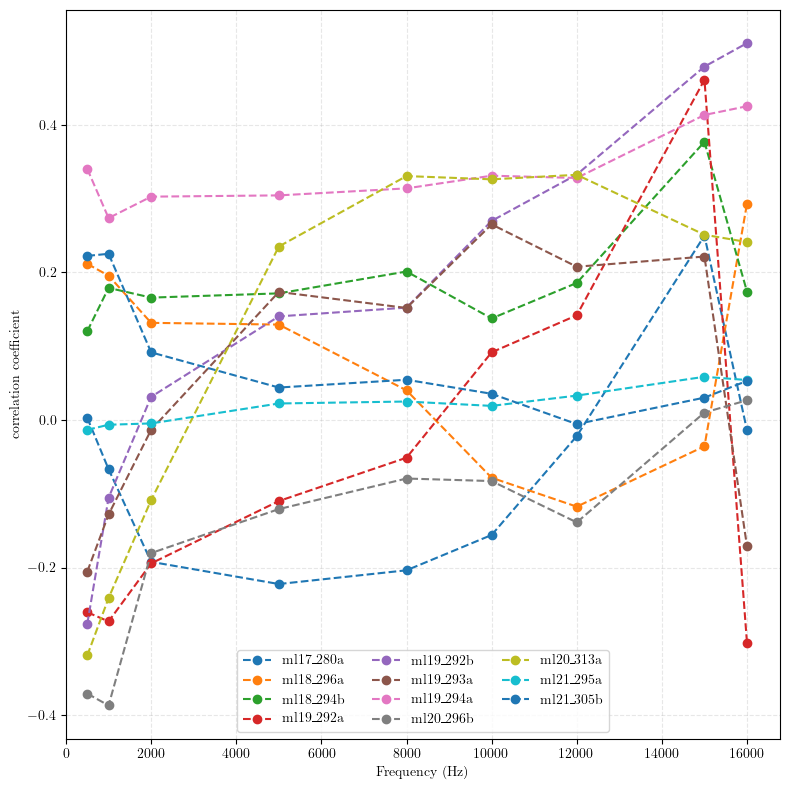

In [42]:
# COR COEF
plt.figure(figsize=(8, 8))
for depid in rslts.keys():
    x_vals = [float(re.search(r'[-+]?\d*\.?\d+', key).group()) for key in rslts[depid].keys()]
    y_vals = [rslts[depid][key]["CC"] for key in rslts[depid].keys()]

    plt.plot(x_vals, y_vals, marker='o', linestyle="--", label=depid)
plt.xlabel("Frequency (Hz)")
plt.ylabel("correlation coefficient")
# plt.ylabel("Mean Absolute Error (mm/h)")
# plt.ylim(0,1)
plt.xlim(0)
# plt.yscale('log')
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="lower center", ncol=3)
plt.tight_layout()
# plt.savefig("../../data-exploration/exports/article/MAE_freq.pdf")

plt.show()

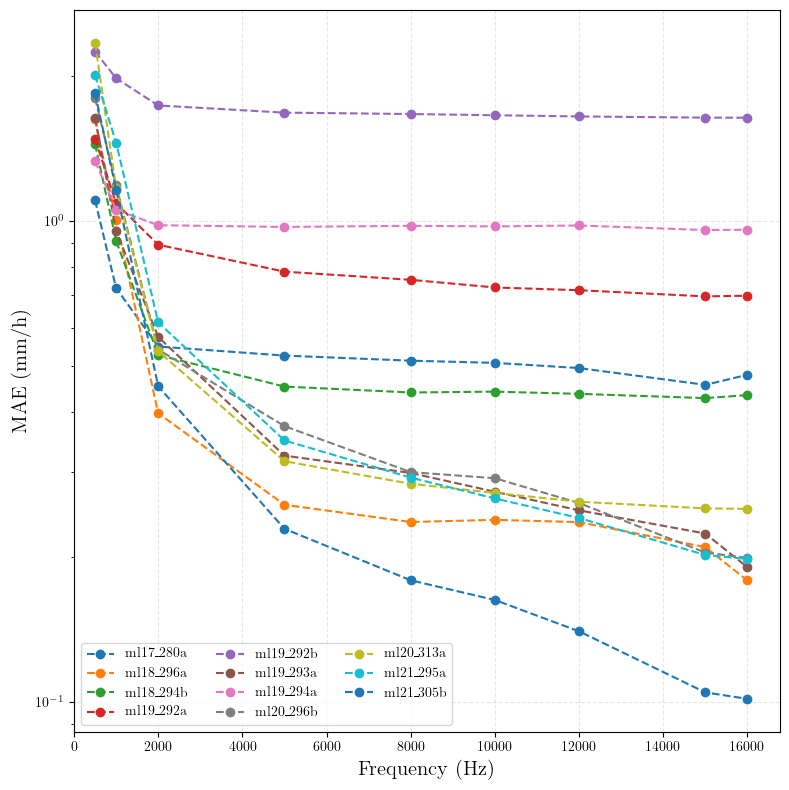

In [ ]:
# MAE
plt.figure(figsize=(8, 8))
for depid in rslts.keys():
    x_vals = [float(re.search(r'[-+]?\d*\.?\d+', key).group()) for key in rslts[depid].keys()]
    y_vals = [rslts[depid][key]["mae"] for key in rslts[depid].keys()]

    plt.plot(x_vals, y_vals, marker='o', linestyle="--", label=depid)
plt.xlabel("Frequency (Hz)", fontsize=15)
plt.ylabel("MAE (mm/h)", fontsize=15)
# plt.ylim(0,1)
plt.xlim(0)
plt.yscale('log')
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(loc="lower left", ncol=3)
plt.tight_layout()
# plt.savefig("../../data-exploration/exports/article/MAE_freq.pdf")

plt.show()

In [118]:
rows = []
for depid, models in rslts.items():
    for model, metrics in models.items():
        rows.append({
            "DepID": depid.replace("_", "\\_"),
            "Frequency": int(re.search(r'\d+$', model).group()),
            "R2": metrics.get("r2"),
        })

df_long = pd.DataFrame(rows)
table_r2 = df_long.pivot(index="Frequency", columns="DepID", values="R2").round(3)

latex_r2 = table_r2.to_latex(
    float_format="%.3f",
    caption="$R^2$ scores per depid for different frequencies",
    label="tab:r2_by_deployment_fitted",
    escape=False
)

print("=== R2 TABLE ===")
print(latex_r2)

=== R2 TABLE ===
\begin{table}
\caption{$R^2$ scores per depid for different frequencies}
\label{tab:r2_by_deployment_fitted}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
DepID & ml17\_280a & ml18\_294b & ml18\_296a & ml19\_292a & ml19\_292b & ml19\_293a & ml19\_294a & ml20\_296b & ml20\_313a & ml21\_295a & ml21\_305b \\
Frequency &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
500 & -1.495 & -3.542 & -32.267 & -0.837 & -0.092 & -12.844 & 0.034 & -12.731 & -30.475 & -6.755 & -102.527 \\
1000 & -0.331 & -0.922 & -12.561 & -0.217 & -0.081 & -3.788 & 0.027 & -5.020 & -7.368 & -3.314 & -40.313 \\
2000 & -0.144 & 0.013 & -1.580 & -0.132 & -0.168 & -1.243 & -0.138 & -0.875 & -1.188 & -1.896 & -5.887 \\
5000 & -0.223 & -0.045 & -0.149 & -0.098 & -0.188 & 0.011 & -0.110 & -0.114 & 0.053 & -0.264 & -0.842 \\
8000 & -0.244 & -0.116 & -0.077 & -0.118 & -0.201 & 0.022 & -0.090 & -0.023 & 0.077 & -0.097 & -0.306 \\
10000 & -0.267 & -0.141 & -0.180 & -0.136 & -0.195 & 0.053 & -0.073 & -0.037 & 0.036 & -0.060

In [94]:
rslts_est = {}

for depid in depids_wo293:
    print(f'>> {depid}')
    rslts_est[depid] = {}

    df = create_df(f"{path}/{depid}/{depid}_dive.csv")
    df = classify_rain(df, offset=1.25, optimised_tresh=False)
    df_r = df[df["Rain_Type_preds"] == "R"].copy()

    for author, a, b in [("Nystuen 2015", -44.35, 30.77),
                         ("Pensieri 2015", -64.40, 25),
                         ("Nystuen 2004", -42.5, 15.4),
                         ("Nystuen 1997", -51.9, 10.6)]:

        rain_est = 10 ** ((df_r["upwards_mean_12000"] + a + 100) / b)
        y_true = df_r["precipitation_GPM"]

        mae = mean_absolute_error(y_true, rain_est)
        mse = mean_squared_error(y_true, rain_est)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, rain_est)
        cc = np.corrcoef(y_true, rain_est)[0, 1]

        rslts_est[depid][author] = {
            "r2": r2,
            "cc": cc,
            "mae": mae,
            "mse": mse,
            "rmse": rmse
        }


>> ml17_280a
>> ml18_296a
>> ml18_294b
>> ml19_292a
>> ml19_292b
>> ml19_293a
>> ml19_294a
>> ml20_296b
>> ml20_313a
>> ml21_295a
>> ml21_305b


In [95]:
rows = []
for depid, models in rslts_est.items():
    for model, metrics in models.items():
        rows.append({
            "DepID": depid.replace("_", "\\_"),
            "Model": model,
            "R2": metrics.get("r2"),
            "CC": metrics.get("cc")
        })

df_long = pd.DataFrame(rows)

table_r2 = df_long.pivot(index="Model", columns="DepID", values="R2").round(3)

latex_r2 = table_r2.to_latex(
    float_format="%.3f",
    caption="$R^2$ scores per depid per coefficient from the bibliography",
    label="tab:r2_by_deployment",
    escape=False
)

print("=== R2 TABLE ===")
print(latex_r2)


=== R2 TABLE ===
\begin{table}
\caption{$R^2$ scores per depid per coefficient from the bibliography}
\label{tab:r2_by_deployment}
\begin{tabular}{lrrrrrrrrrrr}
\toprule
DepID & ml17\_280a & ml18\_294b & ml18\_296a & ml19\_292a & ml19\_292b & ml19\_293a & ml19\_294a & ml20\_296b & ml20\_313a & ml21\_295a & ml21\_305b \\
Model &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
Nystuen 1997 & -201.971 & -234.495 & -14133.091 & -255.896 & -31.924 & -746.485 & -6.445 & -498.115 & -724.112 & -21953.444 & -2101.166 \\
Nystuen 2004 & -655.117 & -802.426 & -13324.349 & -613.327 & -35.271 & -2010.869 & -36.228 & -1768.752 & -1917.627 & -4607.156 & -7232.614 \\
Nystuen 2015 & -17.435 & -21.988 & -184.189 & -10.637 & -0.004 & -58.278 & -0.634 & -57.807 & -55.353 & -20.477 & -292.437 \\
Pensieri 2015 & -0.234 & -0.247 & -7.953 & -0.069 & -0.040 & -1.680 & -0.006 & -2.004 & -1.107 & -0.940 & -10.895 \\
\bottomrule
\end{tabular}
\end{table}

